In [1]:
import sys
sys.path.append('../code') 
import mocap_functions
import numpy as np
import pandas as pd
import neo
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal
from scipy.interpolate import interp1d
import spike_train_functions
import elephant
import quantities as pq
# import h5py
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch
import torch
from torch import nn
import torch.nn.functional as F
from joblib import Parallel, delayed
import multiprocessing
import Neural_Decoding
import pickle
import seaborn as sns
sns.set()
sns.set_style("white")

num_cores = multiprocessing.cpu_count()
scaler = StandardScaler()

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0")
#device = torch.device('cpu')

torch.backends.cudnn.benchmark = True

In [2]:
video_path = '../data/SPK20220308/motion_tracking'

pos_fnames = f'{video_path}/Spike03-08-1557_DLC3D_resnet50_DLCnetwork3D_Spike03-08-1557Sep7shuffle1_500000_AllCam.csv'

eyes_path = f'{video_path}/SpikeCam5_EYES_03-08-1557DLC_resnet50_DLC-eyesNov4shuffle1_40000_el.csv'

## Load Raw Data

In [3]:
cam_df = pd.read_csv(pos_fnames)

# Subtract wrist marker from fingers
forelimb_markers = ['carpal', 'radiusProx', 'radiusDistal', 'ulnarProx', 'ulnarDistal']
wrist_marker = 'carpal'
forelimb_mask = np.logical_or.reduce([cam_df.columns.str.contains(pat=pat) for pat in forelimb_markers])
finger_mask = np.invert(forelimb_mask)

for marker_name in cam_df.columns[finger_mask]:
    if '_x' in marker_name:
        cam_df[marker_name] = cam_df[marker_name] - cam_df[f'{wrist_marker}_x']
    elif '_y' in marker_name:
        cam_df[marker_name] = cam_df[marker_name] - cam_df[f'{wrist_marker}_y']
        
# Calculate grip aperture
cam_df['grip_aperture'] = np.sqrt(
    np.square(cam_df['thumbDistal_x'] - cam_df['indexProx_x']) + 
    np.square(cam_df['thumbDistal_y'] - cam_df['indexProx_y']))

# Load eyes and concatenate marker information into column names from first 3 rows
eyes_df = pd.read_csv(eyes_path, header=[1,2,3]).iloc[:,1:]
eyes_df.columns = ['_'.join(eyes_df.columns[idx]) for idx in range(len(eyes_df.columns))]

# Add columns from eyes_df
cam_df = pd.concat([cam_df, eyes_df], axis=1)

pos_mask = np.logical_or.reduce((cam_df.columns.str.contains(pat='_x'), cam_df.columns.str.contains(pat='_y'), 
                                 cam_df.columns.str.contains(pat='_z')))
marker_names = cam_df.columns[pos_mask].values.tolist()

In [4]:
# Inspect proportion of NaNs where tracking lost
null_percent = cam_df.isnull().astype(int).sum().values / len(cam_df)
sort_indices = np.argsort(null_percent)[::-1]

for name, val in zip(cam_df.columns[sort_indices], null_percent[sort_indices]):
    print(f'| {name} {np.round(val, 2)}', end=' ')

| pinkyDistal_y 0.99 | pinkyDistal_x 0.99 | pinkyMid_y 0.99 | pinkyMid_x 0.99 | pinkyDistal_z 0.99 | pinkyDistal_error 0.99 | ringDistal_y 0.98 | ringDistal_x 0.98 | pinkyMid_error 0.98 | pinkyMid_z 0.98 | ringMid_x 0.97 | ringMid_y 0.97 | ringTip_x 0.97 | ringTip_y 0.97 | pinkyTip_y 0.96 | pinkyTip_x 0.96 | ringDistal_z 0.96 | ringDistal_error 0.96 | pinkyTip_z 0.96 | pinkyTip_error 0.96 | ringMid_z 0.95 | ringMid_error 0.95 | ringTip_error 0.95 | ringTip_z 0.95 | middleTip_y 0.86 | middleTip_x 0.86 | ulnarProx_z 0.85 | ulnarProx_y 0.85 | ulnarProx_x 0.85 | ulnarProx_error 0.85 | middleTip_error 0.83 | middleTip_z 0.83 | radiusProx_error 0.75 | radiusProx_z 0.75 | radiusProx_y 0.75 | radiusProx_x 0.75 | righteye_pupiltop_y 0.65 | righteye_pupiltop_x 0.65 | indextip_y 0.57 | indextip_x 0.57 | indextip_error 0.53 | indextip_z 0.53 | ulnarDistal_error 0.48 | ulnarDistal_x 0.48 | ulnarDistal_y 0.48 | ulnarDistal_z 0.48 | lefteye_pupiltop_x 0.43 | lefteye_pupiltop_y 0.43 | pinkyProx_y 0.41

In [5]:
# Set threshold for likelihood
score_threshold = 0.5

# Pull out marker names stripped of suffix (only markers have scores and likelihood DLC variables)
score_mask = cam_df.columns.str.contains(pat='_x')
score_names = cam_df.columns[score_mask].values
marker_names_stripped = cam_df.columns[score_mask].str.split('_').str[:-1].str.join('_').values

# marker_pos_names indicates which vars are stored in kinematic_df. Only append _x, _y, _z markers
marker_pos_names = list()
for mrk_name in marker_names_stripped:
    # Separate likelihood and position data for 
    mrk_score_mask = np.logical_and(cam_df.columns.str.contains(pat=mrk_name), 
                                    np.logical_or(cam_df.columns.str.contains(pat='error'), 
                                                  cam_df.columns.str.contains(pat='likelihood')))
    mrk_pos_mask = np.logical_and(cam_df.columns.str.contains(pat=mrk_name), 
                                    np.logical_or.reduce((cam_df.columns.str.contains(pat='_x'), 
                                                          cam_df.columns.str.contains(pat='_y'),
                                                          cam_df.columns.str.contains(pat='_z'))))   
    # There should only be 1 likelihood variable, and 2 or 3 position variables
    assert np.sum(mrk_score_mask) == 1
    assert np.sum(mrk_pos_mask) == 2 or np.sum(mrk_pos_mask) == 3
    mrk_score_name = cam_df.columns[mrk_score_mask].values[0]
    pos_name_list = cam_df.columns[mrk_pos_mask].values.tolist()
    marker_pos_names.extend(pos_name_list)

    score_data = cam_df[mrk_score_name].values
    threshold_mask = score_data < score_threshold

    # Set position data values to zero if likelihood below threshold
    for pos_name in pos_name_list:
        pos_data = cam_df[pos_name]
        pos_data[threshold_mask] = 0.0

        # Remove nans
        pos_data = np.nan_to_num(pos_data, copy=True, nan=0.0)
        
        # Update dataframe
        cam_df[pos_name] = pos_data

In [6]:
#Use neo module to load blackrock files
fpath = '../data/SPK20220308/task_data/'
experiment_dict = sio.loadmat(f'{fpath}SPKRH20220308_CB1_ev_explicit.mat')
nev = neo.io.BlackrockIO(f'{fpath}SPKRH20220308_CB1_quiver4toyPKPK4Rotation_delay_001_RETVR_DSXII_corrected.nev')
ns2 = neo.io.BlackrockIO(f'{fpath}SPKRH20220308_CB1_quiver4toyPKPK4Rotation_delay_001.ns2')

nev_seg = nev.read_segment()
tstart = nev_seg.t_start.item()
tstop = nev_seg.t_stop.item()
sampling_rate_list = ns2.header['signal_channels'][['name','sampling_rate']]
sampling_rate = 30000
analog_sampling_rate = 1000
eye_sampling_rate = 500
camera_sampling_rate = 40

#Group spiketrain timestamps by unit id
unit_timestamps = dict()
unit_idx = 0
for st in nev_seg.spiketrains:
    if st.annotations['unit_id'] == 1:
        unit_timestamps[unit_idx] = st.times
        unit_idx += 1

#Grab indeces for camera frames
cam_trigger = ns2.get_analogsignal_chunk(channel_names=['FlirCam']).transpose()[0]
num_analog_samples = len(cam_trigger)
trigger_val = 18000 #threshold where rising edge aligns frame, may need to tweak
cam_frames = np.flatnonzero((cam_trigger[:-1] < trigger_val) & (cam_trigger[1:] > trigger_val))+1


/home/nick/anaconda3/lib/python3.9/site-packages/neo/rawio/blackrockrawio.py:442: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  curr_data = data[mask]


In [7]:
#Load variables from struct (struct indexing is unfortunately hideous)
ev_ex = experiment_dict['df']
gocON = ev_ex['gocON'][0][0][0]
gocOFF = ev_ex['gocOFF'][0][0][0]
stmv = ev_ex['stmv'][0][0][0]
contact = ev_ex['contact'][0][0][0]
reward = ev_ex['reward'][0][0][0]
error = ev_ex['error'][0][0][0]

error_thresh = 5.0 # seconds
# Remove contacts that occur too close to errors
contact_mask = np.ones(len(contact)).astype(bool)
for e_idx, e_ts in enumerate(contact):
    if np.any(np.abs(error - e_ts) < 5):
        contact_mask[e_idx] = False

contact = contact[contact_mask]

In [8]:
#Define game event for alignment, and window around marker
event_ts = contact
#event_ts = event_ts[event_ts < 1000] # events less than 1000 seconds for short DLC tracking
e_start, e_stop = [-2,2]
num_events = len(event_ts)

In [9]:
#Append convolved firing rates to dataframe
kernel_halfwidth = 0.250 #in seconds
kernel = elephant.kernels.RectangularKernel(sigma=kernel_halfwidth/np.sqrt(3)*pq.s)  #***** Change if you want Carlos
sampling_period = 0.01*pq.s
window_length = int((e_stop-e_start)/(sampling_period).item())
    
#List to store neural data
rate_col = list()
unit_col = list()
trial_col_neural = list()

#List to store kinematic data
posData_col = list()
name_col = list()
trial_col_kinematic = list()

kinematic_metadata = dict()
neural_metadata = dict()
for e_idx, e_ts in enumerate(event_ts):
    print(e_idx, end=' ')
    
    #Load kinematic data
    #Identify which frames fall in the time window
    frame_mask = np.logical_and(cam_frames > ((e_ts+e_start) * analog_sampling_rate), cam_frames < ((e_ts+e_stop) * analog_sampling_rate))
    frame_idx = np.flatnonzero(frame_mask) #Pull out indeces of valid frames
    kinematic_metadata[e_idx] = {'time_data':np.linspace(e_ts+e_start, e_ts+e_stop, window_length)}
    
    for mkr in marker_pos_names:
        marker_pos = cam_df[mkr].values[frame_idx]
        f = interp1d(np.linspace(0,1,marker_pos.size), marker_pos)
        marker_interp = f(np.linspace(0,1,window_length))
        
        posData_col.append(marker_interp)
        name_col.append(mkr)
        trial_col_kinematic.append(e_idx)
    
    #Load neural data
    for unit_idx, unit_ts in unit_timestamps.items():
        rate = spike_train_functions.spike_train_rates(unit_ts, e_ts+e_start, e_ts+e_stop, sampling_rate, kernel, sampling_period).transpose()
        
        rate_col.append(rate)
        trial_col_neural.append(e_idx)
        unit_col.append(unit_idx)
        neural_metadata[e_idx] = {'time_data':frame_idx}
   
        
#Pickle convolved rates
neural_dict = {'rates':rate_col, 'unit':unit_col, 'trial':trial_col_neural}
neural_df = pd.DataFrame(neural_dict)
neural_df['count'] = neural_df['rates'].apply(np.sum)


kinematic_dict = {'name':name_col, 'posData':posData_col, 'trial':trial_col_kinematic}
kinematic_df = pd.DataFrame(kinematic_dict)

metadata={'kinematic_metadata':kinematic_metadata, 'neural_metadata':neural_metadata, 'num_trials':num_events, 'kernel_halfwidth':kernel_halfwidth}


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 

In [10]:
#Save DataFrames to temporary folder
kinematic_df.to_pickle(fpath + 'kinematic_df.pkl')
neural_df.to_pickle(fpath + 'neural_df.pkl')

#Save metadata
output = open(fpath + 'metadata.pkl', 'wb')
pickle.dump(metadata, output)
output.close()

## Analyze Data

In [2]:
kinematic_df, neural_df, metadata = mocap_functions.load_mocap_df('../data/SPK20220308/task_data/')

sampling_rate = 100
kernel_offset = int(metadata['kernel_halfwidth'] * sampling_rate)  #Convolution kernel centered at zero, add to neural offset
neural_offset = 20
offset = neural_offset + kernel_offset
window_size = 20
data_step_size = 1 

num_trials = metadata['num_trials']

#Generate cv_dict for regular train/test/validate split (no rolling window)
cv_split = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
val_split = ShuffleSplit(n_splits=1, test_size=.25, random_state=0)
cv_dict = {}
for fold, (train_val_idx, test_idx) in enumerate(cv_split.split(np.arange(num_trials))):
    for t_idx, v_idx in val_split.split(train_val_idx): #No looping, just used to split train/validation sets
        cv_dict[fold] = {'train_idx':train_val_idx[t_idx], 
                         'test_idx':test_idx, 
                         'validation_idx':train_val_idx[v_idx]} 

In [3]:
# Set up PyTorch Dataloaders
fold=0
kinematic_type = 'posData'
# Parameters
batch_size = 10000
train_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
train_eval_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}
validation_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
test_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}

predict_kinematics=False
# Generators
training_set = mocap_functions.SEE_Dataset(cv_dict, fold, 'train_idx', kinematic_df, neural_df, offset, window_size, 
                                            data_step_size, device, 'posData', True, predict_kinematics)
training_generator = torch.utils.data.DataLoader(training_set, **train_params)
training_eval_generator = torch.utils.data.DataLoader(training_set, **train_eval_params)
X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

validation_set = mocap_functions.SEE_Dataset(cv_dict, fold, 'validation_idx', kinematic_df, neural_df, offset, window_size, 
                                                data_step_size, device, 'posData', True, predict_kinematics)
validation_generator = torch.utils.data.DataLoader(validation_set, **validation_params)

testing_set = mocap_functions.SEE_Dataset(cv_dict, fold, 'test_idx', kinematic_df, neural_df, offset, window_size, 
                                                data_step_size, device, 'posData', True, predict_kinematics)
testing_generator = torch.utils.data.DataLoader(testing_set, **test_params)
X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

Kalman Filter decoding

In [4]:
#Fit and run kalman filter
model_kf = Neural_Decoding.decoders.WienerFilterDecoder() 
model_kf.fit(X_train_data,y_train_data)

kf_train_pred = model_kf.predict(X_train_data)
kf_test_pred = model_kf.predict(X_test_data)

#Compute decoding performance
kf_train_corr = mocap_functions.matrix_corr(kf_train_pred,y_train_data)
kf_test_corr = mocap_functions.matrix_corr(kf_test_pred,y_test_data)


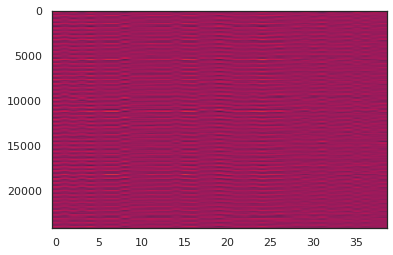

In [5]:
%matplotlib inline
plt.imshow(kf_test_pred,aspect='auto')

ANN Decoding

In [6]:
#Define hyperparameters
lr = 1e-2
weight_decay = 1e-5
layer_size=[10]
max_epochs=1000
input_size = training_set[0][0].shape[1] 
output_size = training_set[0][1].shape[1] 

model_ann = mocap_functions.model_ann(input_size,output_size,layer_size).to(device)
# Define Loss, Optimizerints h
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_ann.parameters(), lr=lr, weight_decay=weight_decay)

In [7]:
#Train model
loss_dict = mocap_functions.train_validate_model(model_ann, optimizer, criterion, max_epochs, training_generator, validation_generator, device, 10, 5)

/home/nick/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


**********
Epoch: 10/1000 ... Train Loss: 0.6982  ... Validation Loss: 0.7091
**********
Epoch: 20/1000 ... Train Loss: 0.6638  ... Validation Loss: 0.6838
**********
Epoch: 30/1000 ... Train Loss: 0.6528  ... Validation Loss: 0.6749
...***.*.*
Epoch: 40/1000 ... Train Loss: 0.6469  ... Validation Loss: 0.6726
*.*.*.*..*
Epoch: 50/1000 ... Train Loss: 0.6395  ... Validation Loss: 0.6681
****......
Epoch: 60/1000 ... Train Loss: 0.6367  ... Validation Loss: 0.6658
 Early Stop; Min Epoch: 54


In [8]:
#Evaluate trained model
ann_train_pred = mocap_functions.evaluate_model(model_ann, training_eval_generator, device)
ann_test_pred = mocap_functions.evaluate_model(model_ann, testing_generator, device)

#Compute decoding performance
ann_train_corr = mocap_functions.matrix_corr(ann_train_pred,y_train_data)
ann_test_corr = mocap_functions.matrix_corr(ann_test_pred,y_test_data)


AttributeError: module 'mocap_functions' has no attribute 'evaluate_model'

Visualize Results

In [ ]:
#Testing Data
start=23
plt.figure(figsize=(12,8))
bounds = np.arange(1,2000)
x_vals = np.arange(len(bounds)) / 100
for plot_idx, unit_idx in enumerate(range(start, start+4)):
    plt.subplot(2,2,plot_idx+1)
    plt.plot(x_vals,y_test_data[bounds,unit_idx])
    plt.plot(x_vals,kf_test_pred[bounds,unit_idx])
    plt.plot(x_vals,ann_test_pred[bounds,unit_idx])
    plt.title('Unit ' + str(unit_idx))
    plt.xlabel('Time (s)')
    plt.ylabel('Firing Rate (a.u.)')
    if plot_idx==1:
        plt.legend(['Real', 'KF', 'ANN'], loc=1)
plt.tight_layout()